In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

sys.path.insert(0, '/Users/diol5851/Documents/rental-housing-cost/')
from notebooks.data_cleaning_EDA.AHS_Parser import AHS_Parser
sys.path.remove('/Users/diol5851/Documents/rental-housing-cost/')

In [2]:
def get_dataset(year):
    raw_dat = pd.read_feather(f'../../data/AHS_{year}.feather')
    # Drop the year column, since that does not add information here.
    dat = raw_dat.drop(columns=['YEAR'])
    # Move ADEQUACY to the first column.
    adequacy = dat.pop('ADEQUACY')
    dat.insert(0, 'ADEQUACY', adequacy)
    # Drop apartments with four or more bathrooms.
    dat = dat[dat['BATHROOMS'] < 4]
    # Remap the ADEQUACY column to a binary column, where 1 is adequate.
    ad_default = defaultdict(lambda: 0)
    ad_default['Adequate'] = 1
    dat['ADEQUACY'] = dat['ADEQUACY'].map(ad_default)
    # Dropping columns that seem redundant for prediction.
    dat = dat.drop(columns = [
        'UTILAMT', 'HOAAMT', 'INSURAMT', 'FINCP', 'KITCHENS', 'DINING', 'LAUNDY', 'GARAGE', 'PORCH',
        'NUMNONREL', 'HHADLTKIDS', 'SUBDIV'
        ])
    # Parse the remaining categorical columns.
    parser = AHS_Parser()
    for col in dat.select_dtypes(include=['object']).columns:
        dat[col] = dat[col].astype('category')
        dat[col] = dat[col].cat.rename_categories(parser.parse_categorical(col, year))
        if 'Not reported' in dat[col].cat.categories:
            dat[col] = dat[col].cat.remove_categories(['Not reported'])
    # Drop columns with less than 20k non-null values.
    dat = dat.drop(columns = dat.columns[dat.count() < 20e3])
    # Drop all remaining null values.
    dat = dat.dropna()
    return dat

In [3]:
# Pull the 2023 AHS data.
dat = get_dataset(2023)
dat.drop(columns=['OMB13CBSA', 'ROACH', 'RODENT', 'SEWBREAK'], inplace=True)
dat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19997 entries, 0 to 55667
Data columns (total 32 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ADEQUACY    19997 non-null  int64   
 1   BLD         19997 non-null  category
 2   STORIES     19997 non-null  int64   
 3   YRBUILT     19997 non-null  int64   
 4   RENT        19997 non-null  int64   
 5   RENTSUB     19997 non-null  category
 6   TOTHCAMT    19997 non-null  int64   
 7   UNITFLOORS  19997 non-null  int64   
 8   BATHROOMS   19997 non-null  float64 
 9   BEDROOMS    19997 non-null  int64   
 10  TOTROOMS    19997 non-null  int64   
 11  ACPRIMARY   19997 non-null  category
 12  HEATTYPE    19997 non-null  category
 13  HOTWATER    19997 non-null  category
 14  SEWTYPE     19997 non-null  category
 15  WATSOURCE   19997 non-null  category
 16  COOKTYPE    19997 non-null  category
 17  DRYER       19997 non-null  category
 18  HINCP       19997 non-null  int64   
 19  NUMPEOPLE

In [4]:
## Must encode the cateogorical variables before fitting the model.
from sklearn.preprocessing import LabelEncoder

# Get the categorical columns.
cols = dat.select_dtypes(include=['category']).columns

for col in cols:
    # This does not save the encoders, which is fine for generating on a static dataset,
    # but if we want to use this model in production, we will need to save the encoders
    # for each column to transform data the same way.
    le = LabelEncoder()
    dat[col] = le.fit_transform(dat[col])

## Generate training and test sets.
dat_adequate = dat[dat['ADEQUACY'] == 1]
dat_not_adequate = dat[dat['ADEQUACY'] == 0]
# Split the two dataframes into training and testing sets.
adequate_train, adequate_test = train_test_split(dat_adequate, test_size=0.2, random_state=42)
not_adequate_train, not_adequate_test = train_test_split(dat_not_adequate, test_size=0.2, random_state=42)
# Combine the two classes.
train = pd.concat([adequate_train.sample(not_adequate_train.shape[0]), not_adequate_train])
test = pd.concat([adequate_test, not_adequate_test])

In [5]:
## Fit a decision tree.
tree_mod = DecisionTreeClassifier(max_depth=4, random_state=42, criterion='entropy')
tree_mod.fit(train.drop(columns=['ADEQUACY']), train['ADEQUACY'])

## Predict on the test set.
pred = tree_mod.predict(test.drop(columns=['ADEQUACY']))

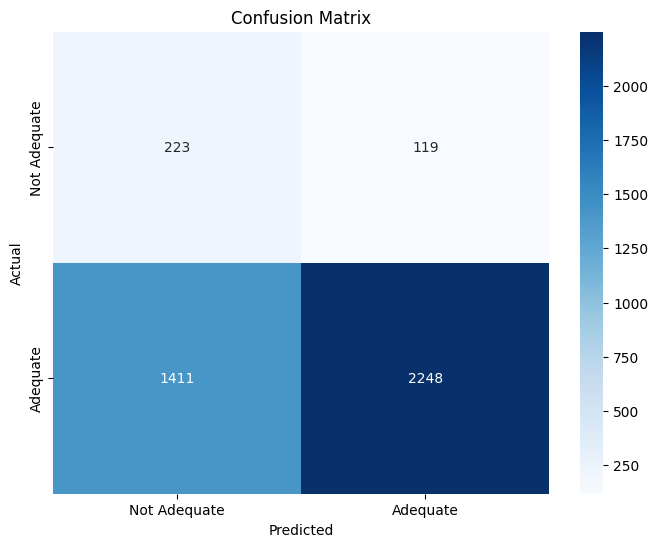

Accuracy: 0.618


In [6]:
## Generate the confusion matrix.
cm = confusion_matrix(test['ADEQUACY'], pred)
# Plot the confusion matrix.
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Adequate', 'Adequate'], yticklabels=['Not Adequate', 'Adequate'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
## Print accuracy.
acc = cm.diagonal().sum() / cm.sum()
print(f'Accuracy: {acc:.3f}')

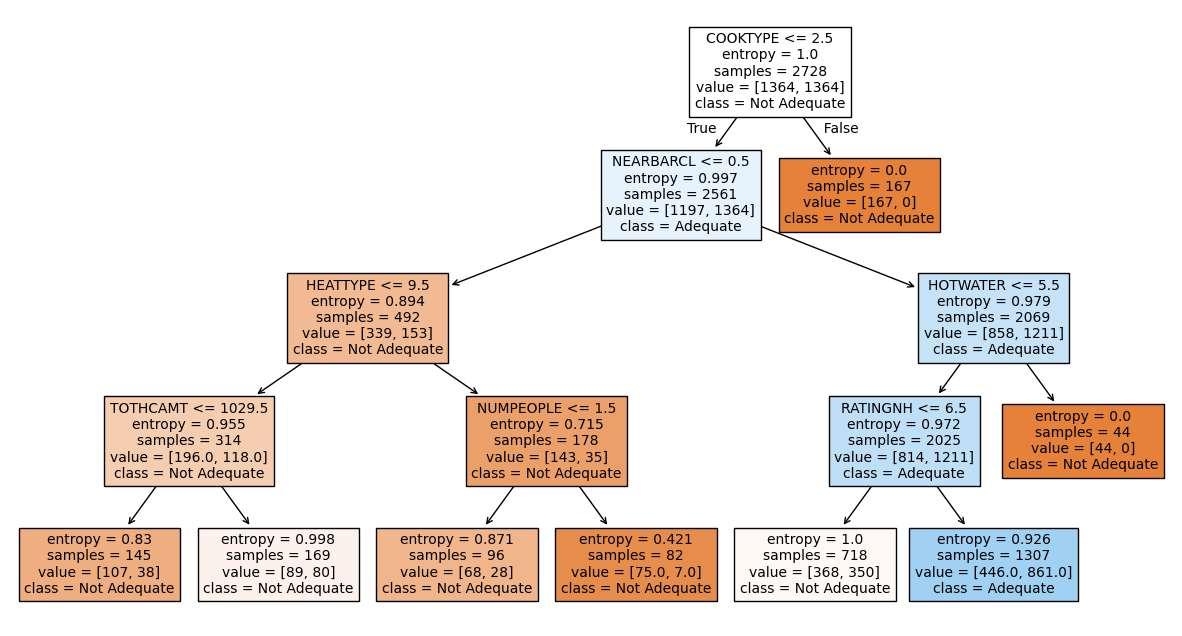

In [7]:
from sklearn import tree
plt.figure(figsize=(15, 8))
tree.plot_tree(
    tree_mod,
    feature_names=train.drop(columns=['ADEQUACY']).columns,
    class_names=['Not Adequate', 'Adequate'],
    filled=True,
    fontsize=10,
)
plt.show()

## Try Random Forests

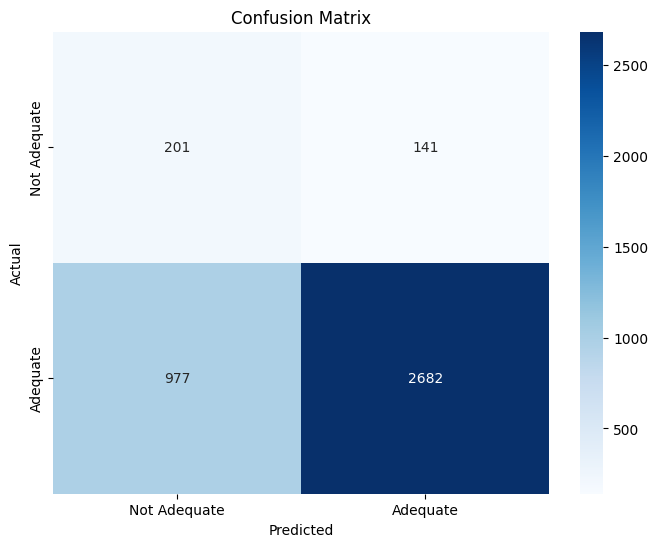

Accuracy: 0.721


In [8]:
## Fit the forest.
forest_mod = RandomForestClassifier(n_estimators = 100, max_depth = 4, random_state=42, criterion='entropy')
forest_mod.fit(train.drop(columns=['ADEQUACY']), train['ADEQUACY'])
## Predict on the test set.
pred = forest_mod.predict(test.drop(columns=['ADEQUACY']))
## Generate the confusion matrix.
cm = confusion_matrix(test['ADEQUACY'], pred)
# Plot the confusion matrix.
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Adequate', 'Adequate'], yticklabels=['Not Adequate', 'Adequate'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
## Print accuracy.
acc = cm.diagonal().sum() / cm.sum()
print(f'Accuracy: {acc:.3f}')

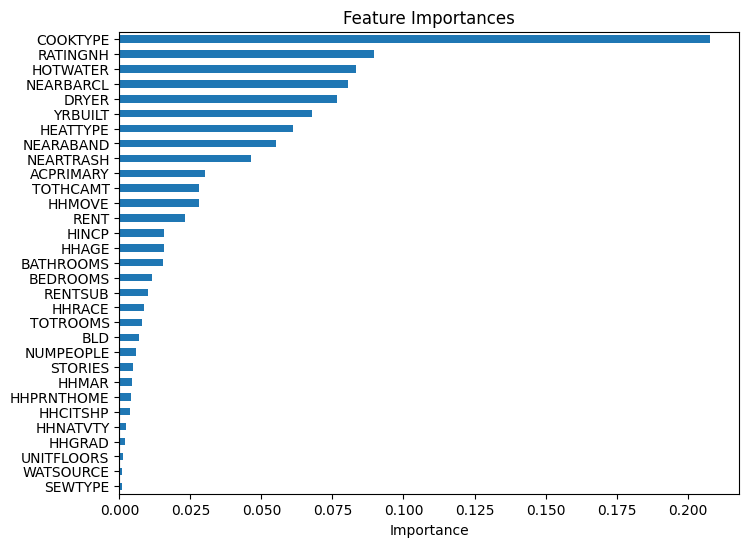

In [9]:
pd.Series(
    forest_mod.feature_importances_, 
    index=train.drop(columns=['ADEQUACY']).columns
).sort_values(
    ascending=True
).plot(
    kind='barh',
    figsize=(8, 6),
    title='Feature Importances',
    xlabel='Importance',
)
plt.show()